# Data Preprocessing

In [106]:
import numpy as np
import pandas as pd
import re
import os
import math
import keras
import librosa
import librosa.display
from tqdm import tqdm
from sklearn import metrics
from datetime import datetime
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [3]:
FILE_PATH = '../Data Sets/esc_50/'

In [4]:
metadata = pd.read_csv(os.path.join(FILE_PATH,'meta/esc50.csv'))

In [5]:
metadata.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [6]:
len(metadata)

2000

In [7]:
metadata['category'].value_counts()

airplane            40
helicopter          40
cat                 40
laughing            40
toilet_flush        40
sneezing            40
pig                 40
sheep               40
fireworks           40
footsteps           40
washing_machine     40
crickets            40
mouse_click         40
door_wood_creaks    40
door_wood_knock     40
crackling_fire      40
thunderstorm        40
can_opening         40
clock_tick          40
siren               40
insects             40
wind                40
church_bells        40
clock_alarm         40
chirping_birds      40
frog                40
car_horn            40
rooster             40
dog                 40
keyboard_typing     40
glass_breaking      40
hen                 40
vacuum_cleaner      40
train               40
sea_waves           40
hand_saw            40
crying_baby         40
water_drops         40
crow                40
cow                 40
breathing           40
pouring_water       40
clapping            40
coughing   

In [8]:
metadata['fold'].value_counts()

1    400
2    400
3    400
4    400
5    400
Name: fold, dtype: int64

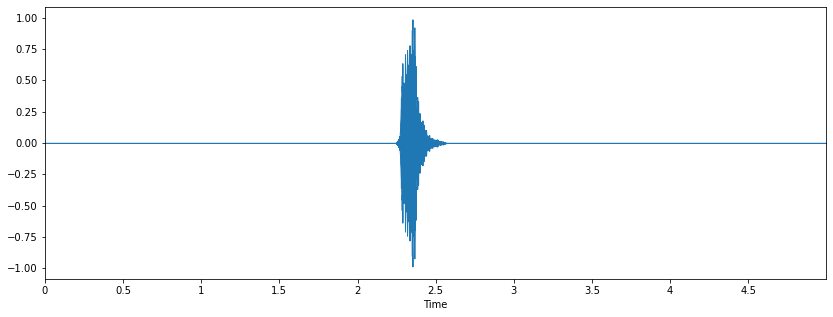

In [9]:
filename = 'C:\\Users\\Kaviarasan\\Data Science\\Data Sets\\esc_50\\audio\\1-100032-A-0.wav'

plt.figure(figsize=(14,5))
data,sample_rate=librosa.load(filename)
librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

In [10]:
audio_files=[]
animals=['dog','rooster','pig','cow','frog','cat','hen','insects','sheep','crow']

for index_num,row in tqdm(metadata.iterrows()):
    if row['category'] in animals:
        file_name = os.path.join(os.path.abspath(FILE_PATH),'audio',str(row["filename"]))
        class_labels=row["category"]
        audio_files.append([file_name,class_labels])
        
data = pd.DataFrame(audio_files,columns=['filename','class'])
data.head()

2000it [00:00, 2987.47it/s]


,filename,class
0,C:\Users\Kaviarasan\Data Science\Data Sets\esc...,dog
1,C:\Users\Kaviarasan\Data Science\Data Sets\esc...,crow
2,C:\Users\Kaviarasan\Data Science\Data Sets\esc...,dog
3,C:\Users\Kaviarasan\Data Science\Data Sets\esc...,sheep
4,C:\Users\Kaviarasan\Data Science\Data Sets\esc...,frog


In [11]:
len(data)

400

In [108]:
FRAME_SIZE=2048
HOP_SIZE=512
SAMPLE_RATE=22050
MELS = 10
LEARNING_RATE=0.01

# Data Analysis

## Time Domain Features

    1. Root Mean Square Error:

In [91]:
signal,sr = librosa.load(audio_files[0][0])

In [94]:
rms_dog = librosa.feature.rms(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]

In [95]:
frames = range(len(rms_dog))
t = librosa.frames_to_time(frames, hop_length=HOP_SIZE)

In [100]:
def waveplot(t,rms,data,title):
    
    plt.figure(figsize=(14, 5))
    librosa.display.waveplot(data,sr=SAMPLE_RATE, alpha=0.5)
    plt.plot(t, rms, color="r")
    plt.ylim((-1, 1))
    plt.title(title)

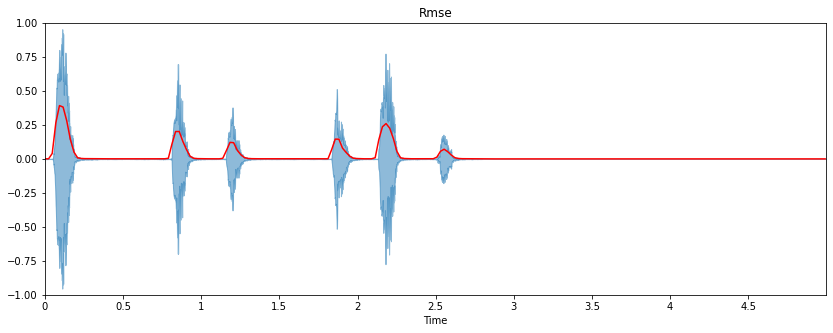

In [102]:
waveplot(t,rms_dog,signal,"Rmse")

    2. Zero-Crossing Rate :

In [103]:
zcr_dog = librosa.feature.zero_crossing_rate(signal, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]

In [104]:
frames = range(len(zcr_dog))
t = librosa.frames_to_time(frames, hop_length=HOP_SIZE)

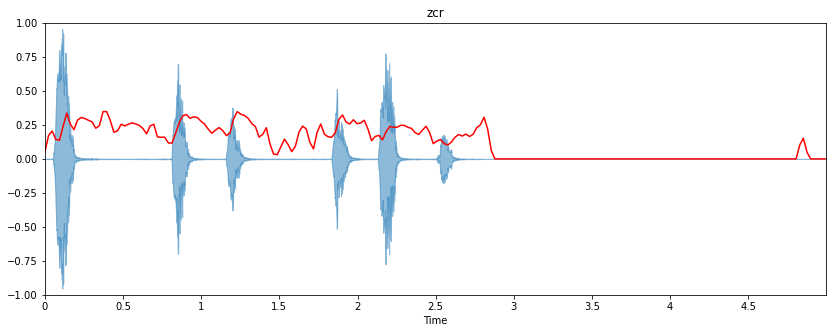

In [106]:
waveplot(t,zcr_dog,signal,"zcr")

    3. Amplitude Envelope :

In [107]:
amplitude_envelope = [max(signal[i:i+FRAME_SIZE]) for i in range(0,len(signal),HOP_SIZE)]

In [108]:
frames = range(len(amplitude_envelope))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

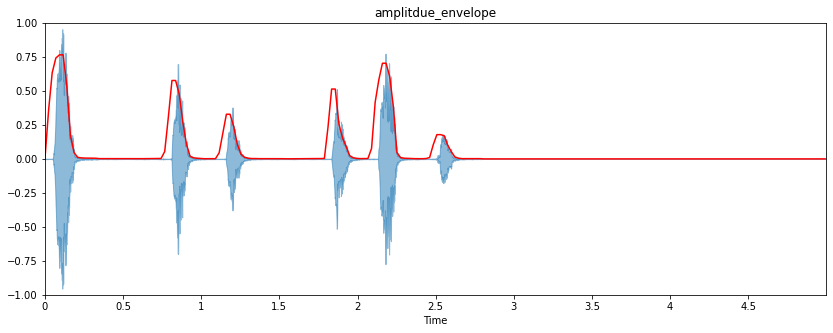

In [109]:
waveplot(t,amplitude_envelope,signal,"amplitdue_envelope")

## Discrete Fourier Transform

    Which is used to transform signal from time to frequency

In [41]:
ft=[]
i=1

for audio in audio_files:
    print(i)
    sound,sr = librosa.load(audio[0])
    scale = np.fft.fft(sound)
    ft.append(scale)
    i+=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [43]:
ft[0].shape

(110250,)

In [44]:
magnitude = [np.abs(value) for value in ft]

In [52]:
def plot_magnitude_spectrum(magnitude, sr, title, f_ratio=1):

    plt.figure(figsize=(18, 5))    
    frequency = np.linspace(0, SAMPLE_RATE, len(magnitude))
    frequency_ratio = int( len(magnitude)*f_ratio )
    
    plt.plot(frequency[:frequency_ratio], magnitude[:frequency_ratio])
    plt.xlabel('Frequency (Hz)')
    plt.xlabel('Magnitude')
    plt.title(title)

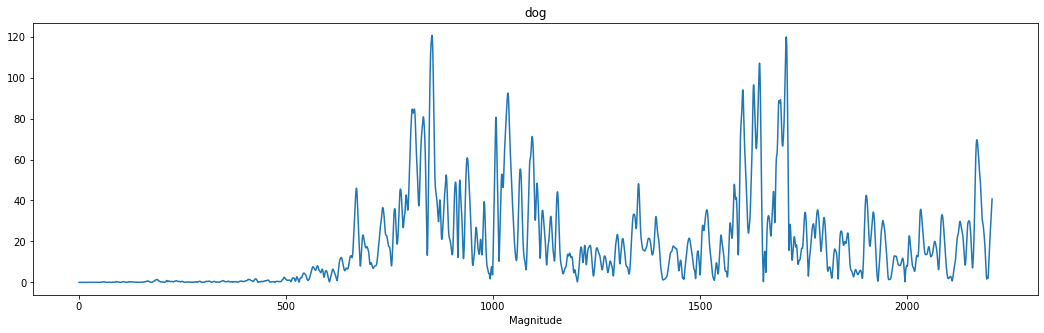

In [53]:
plot_magnitude_spectrum(magnitude[0], SAMPLE_RATE, "dog",0.1)

## Spectrogram
    Visualizing Spectrogram

In [30]:
spectrogram=[]
i=1

for audio in audio_files:
    print(i)
    sound,sr = librosa.load(audio[0])
    scale = librosa.stft(sound, n_fft=FRAME_SIZE, hop_length=HOP_SIZE) #short-term-fourier-transform
    spectrogram.append(scale)
    i+=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [40]:
spectrogram[0]

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
      dtype=complex64)

In [31]:
#(frequency_bins,frame)
spectrogram[0].shape

(1025, 216)

In [32]:
type(spectrogram[0])

numpy.ndarray

In [33]:
spec = [np.abs(value) ** 2 for value in spectrogram]

In [37]:
def plot_spectrogram(data, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(data, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")

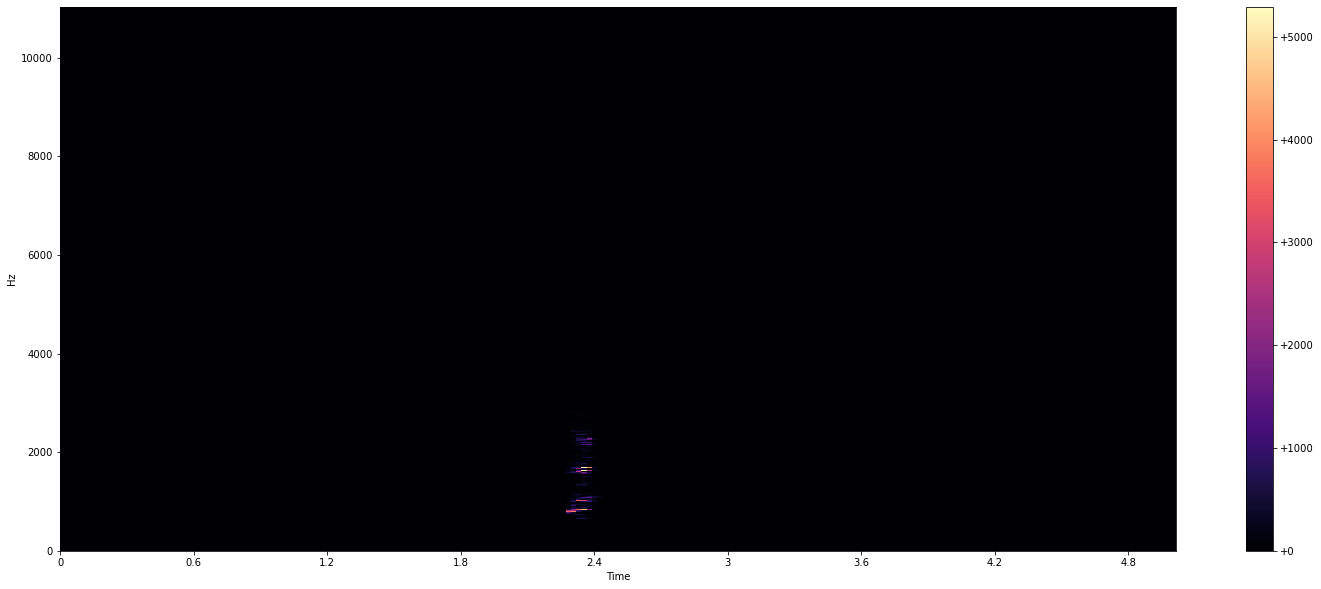

In [38]:
plot_spectrogram(spec[0], SAMPLE_RATE, HOP_SIZE)

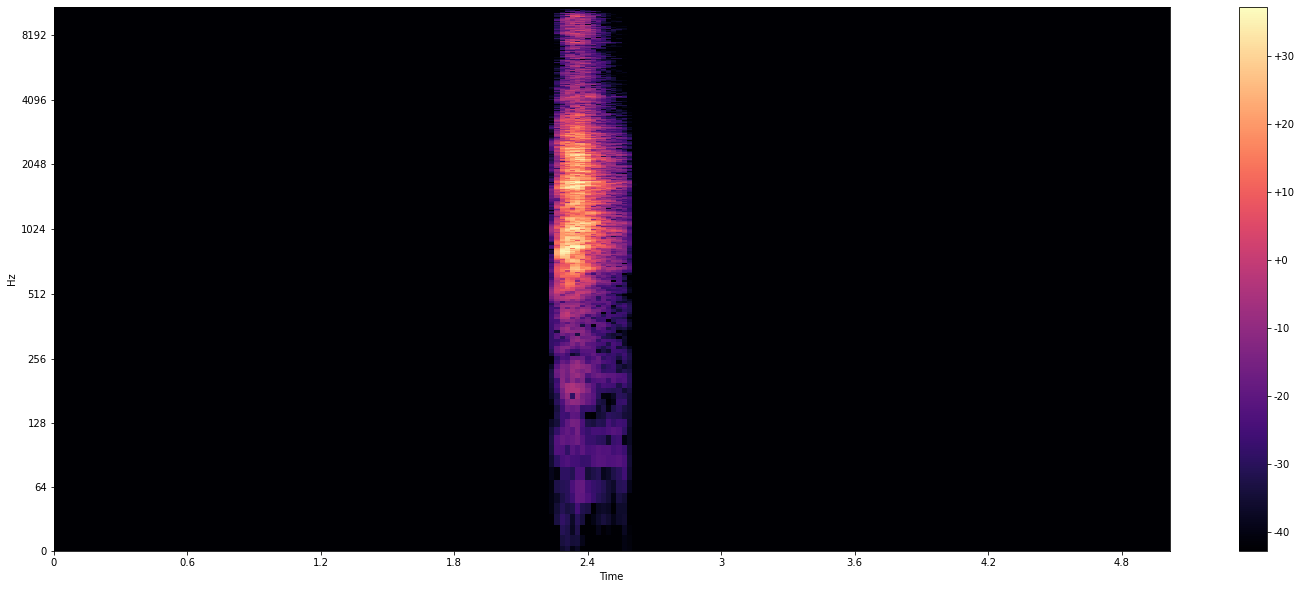

In [39]:
log_scale = [librosa.power_to_db(scale) for scale in spec]
plot_spectrogram(log_scale[0],SAMPLE_RATE,HOP_SIZE,y_axis="log")

## Frequency Domain Features

    1. Band Energy Ratio :

In [57]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):

    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [58]:
split_frequency_bin = calculate_split_frequency_bin(2000, SAMPLE_RATE, 1025)
split_frequency_bin

185

In [59]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):

    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []

    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

In [60]:
dog = band_energy_ratio(spectrogram[0],2000,SAMPLE_RATE)

<ipython-input-59-867bdbc8f2ca>:12: RuntimeWarning: invalid value encountered in float_scalars
  band_energy_ratio_current_frame = sum_power_low_frequencies / sum_power_high_frequencies


In [61]:
len(dog) #frames

216

In [62]:
frames = range(len(dog))
t = librosa.frames_to_time(frames, hop_length=HOP_SIZE)

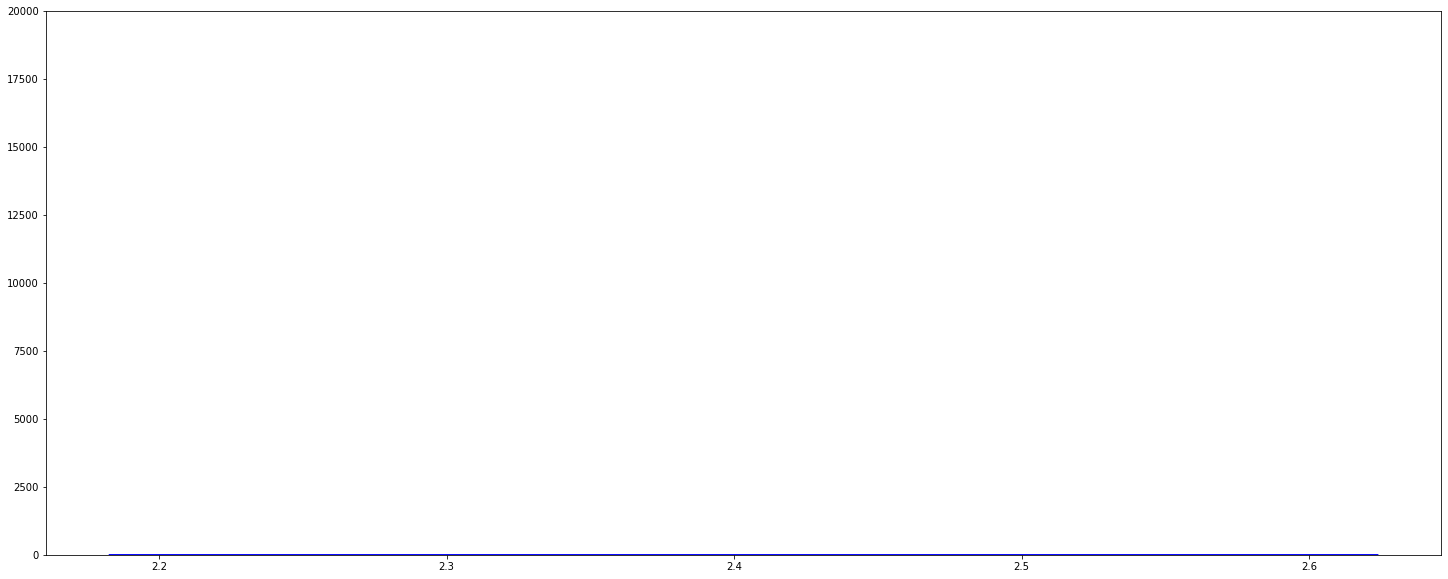

In [72]:
plt.figure(figsize=(25, 10))
plt.plot(t,dog, color="b")
plt.ylim((0, 20000))
plt.show()

    2. Spectral Bandwidth :

In [112]:
filename = 'C:\\Users\\Kaviarasan\\Data Science\\Data Sets\\esc_50\\audio\\1-100032-A-0.wav'

signal,sr = librosa.load(filename)
bandwidth = librosa.feature.spectral_bandwidth(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]

In [114]:
bandwidth.shape

(216,)

In [115]:
frames = range(0,len(bandwidth))
time = librosa.frames_to_time(frames,HOP_SIZE)

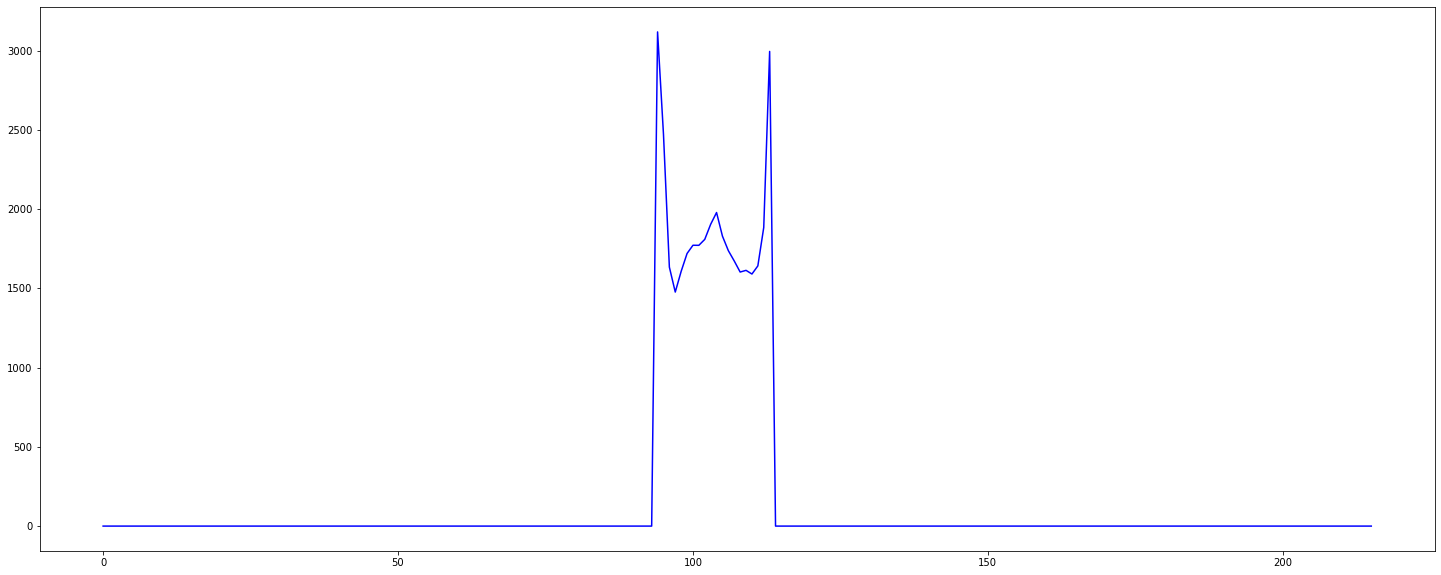

In [116]:
plt.figure(figsize=(25,10))
plt.plot(time, bandwidth, color='b')
plt.show()

## Mel-Spectrogram

In [11]:
filter_banks = librosa.filters.mel(sr=SAMPLE_RATE,n_fft=FRAME_SIZE,n_mels=MELS)

In [12]:
filter_banks.shape

(10, 1025)

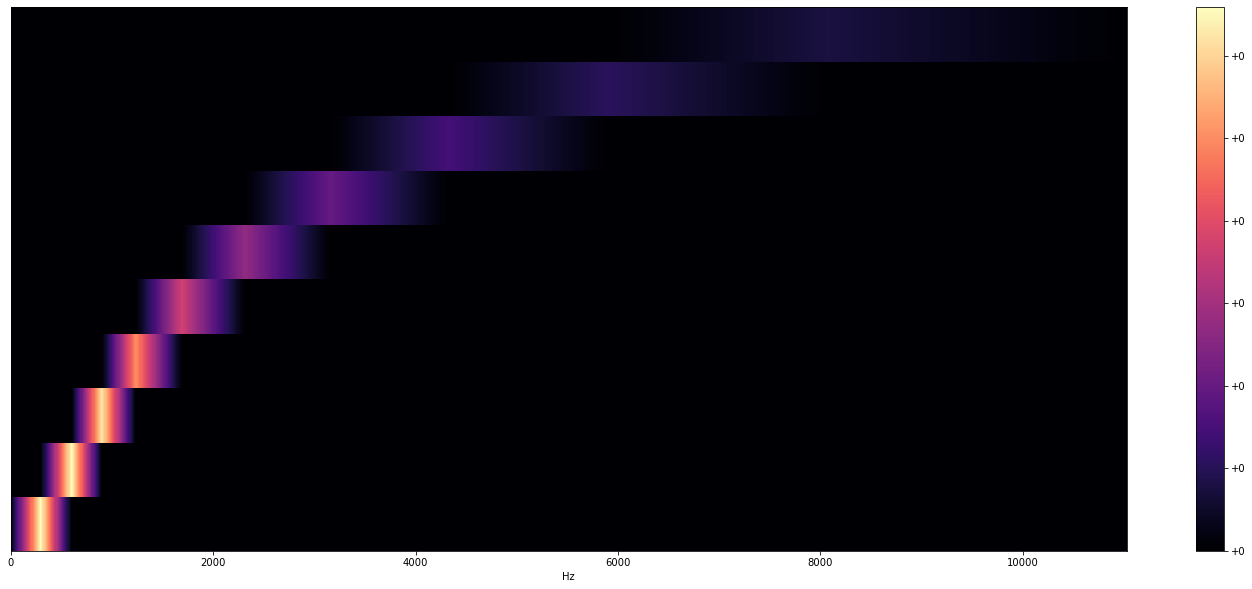

In [13]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(filter_banks, 
                         sr=SAMPLE_RATE, 
                         x_axis="linear")
plt.colorbar(format="%+2.f")
plt.show()

In [20]:
mel=[]
i=1
for audio in audio_files:
    print(i)
    sound,sr = librosa.load(audio[0])
    mel_spectrogram = librosa.feature.melspectrogram(sound, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE, n_mels=MELS)
    mel.append(mel_spectrogram)
    i+=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [24]:
mel[0].shape

(10, 216)

In [25]:
log_mel_spectrogram = [librosa.power_to_db(mels) for mels in mel]

In [27]:
log_mel_spectrogram[0].shape

(10, 216)

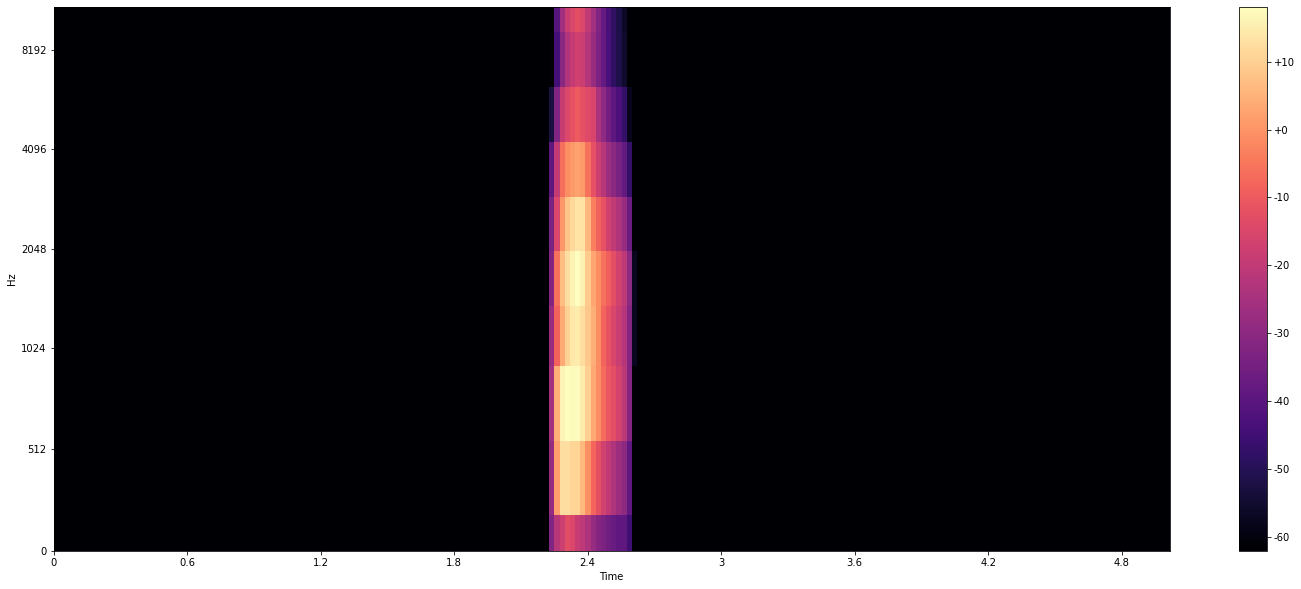

In [28]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(log_mel_spectrogram[0], 
                         x_axis="time",
                         y_axis="mel", 
                         sr=SAMPLE_RATE)
plt.colorbar(format="%+2.f")
plt.show()

## Mel-Frequency Cepstral Coefficients (MFCC)

    1. We're avg the the total 216 frames and using these mfcc values in ANN model

In [13]:
mfcc_mean=[]

for index_num,row in tqdm(data.iterrows()):
    filename = os.path.join(os.path.abspath(FILE_PATH),str(row["filename"]))
    class_labels=row["class"]
    signal,sr = librosa.load(filename)
    mfccs = librosa.feature.mfcc(y=signal,n_mfcc=13,sr=sr)
    mfccs_scaled_features = np.mean(mfccs.T,axis=0)
    mfcc_mean.append([mfccs_scaled_features,class_labels])

400it [04:45,  1.40it/s]


In [14]:
mfcc_mean[0][0]

array([-6.0096918e+02,  4.7353296e+00, -8.5468931e+00, -4.2358022e+00,
       -8.5924041e-01, -1.9330620e+00, -3.3468971e-01,  8.6515081e-01,
        7.8212482e-01,  4.7982031e-01, -5.1504910e-01, -2.0849331e-01,
       -8.9801002e-01], dtype=float32)

In [17]:
mfcc_mean[0][0].shape

(13,)

    Note : Below Spectrogram displays are have shape of (13,216) so I displayed them
    but above I've averged the total frames for ann model creation so we cannot display spectrograms
    
    2. Below mfcc values are used in CNN model

In [78]:
mfcc=[]
labels=[]

for index_num,row in tqdm(data.iterrows()):
    filename = os.path.join(os.path.abspath(FILE_PATH),str(row["filename"]))
    class_labels=row["class"]
    signal,sr = librosa.load(filename)
    mfccs = librosa.feature.mfcc(y=signal,n_mfcc=13,sr=sr)
    mfcc.append(mfccs)
    labels.append(class_labels)

400it [04:28,  1.49it/s]


In [80]:
mfcc[0]

array([[-629.03265, -629.03265, -629.03265, ..., -629.03265, -629.03265,
        -629.03265],
       [   0.     ,    0.     ,    0.     , ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,    0.     ,    0.     , ...,    0.     ,    0.     ,
           0.     ],
       ...,
       [   0.     ,    0.     ,    0.     , ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,    0.     ,    0.     , ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,    0.     ,    0.     , ...,    0.     ,    0.     ,
           0.     ]], dtype=float32)

In [82]:
mfcc[0].shape

(13, 216)

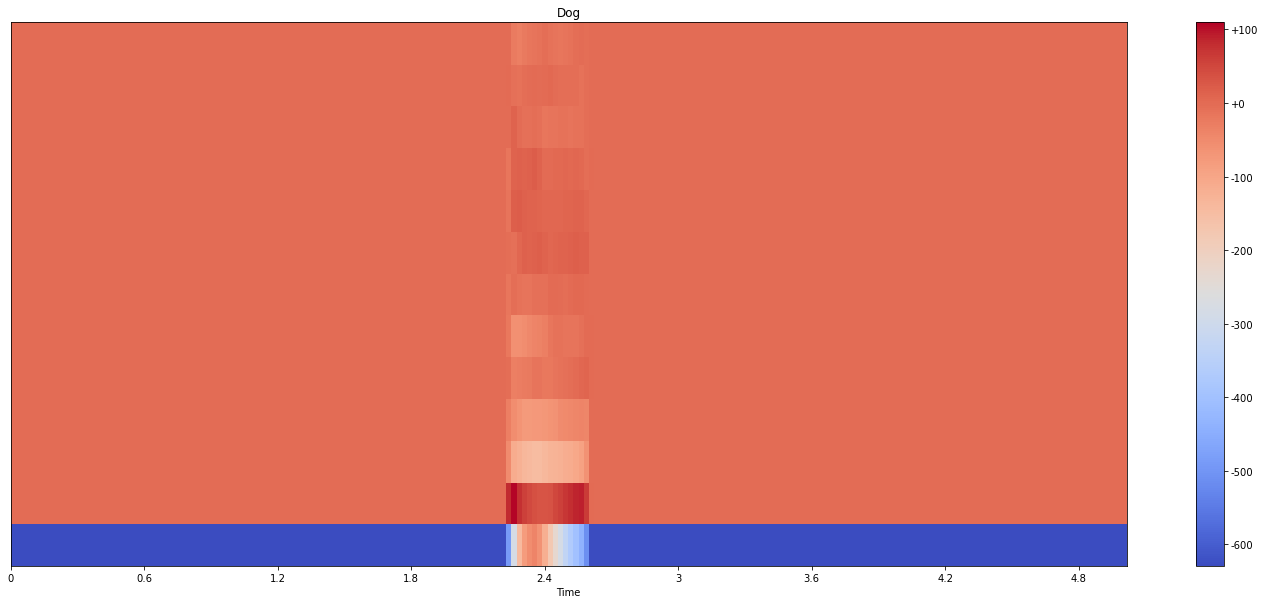

In [83]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(mfcc[0], 
                         x_axis="time", 
                         sr=SAMPLE_RATE)
plt.colorbar(format="%+2.f")
plt.title('Dog')
plt.show()

In [84]:
delta1 = librosa.feature.delta(mfcc[0])
delta2 = librosa.feature.delta(mfcc[0],order=2)

In [85]:
delta2.shape

(13, 216)

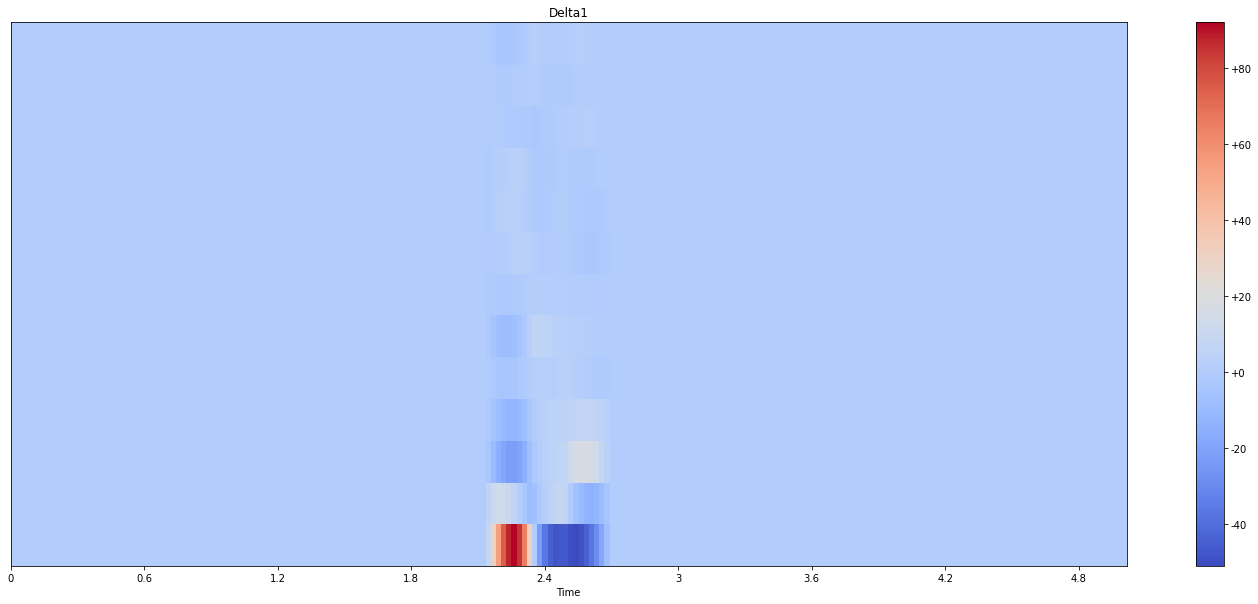

In [86]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(delta1, 
                         x_axis="time", 
                         sr=SAMPLE_RATE)
plt.title('Delta1')
plt.colorbar(format="%+2.f")

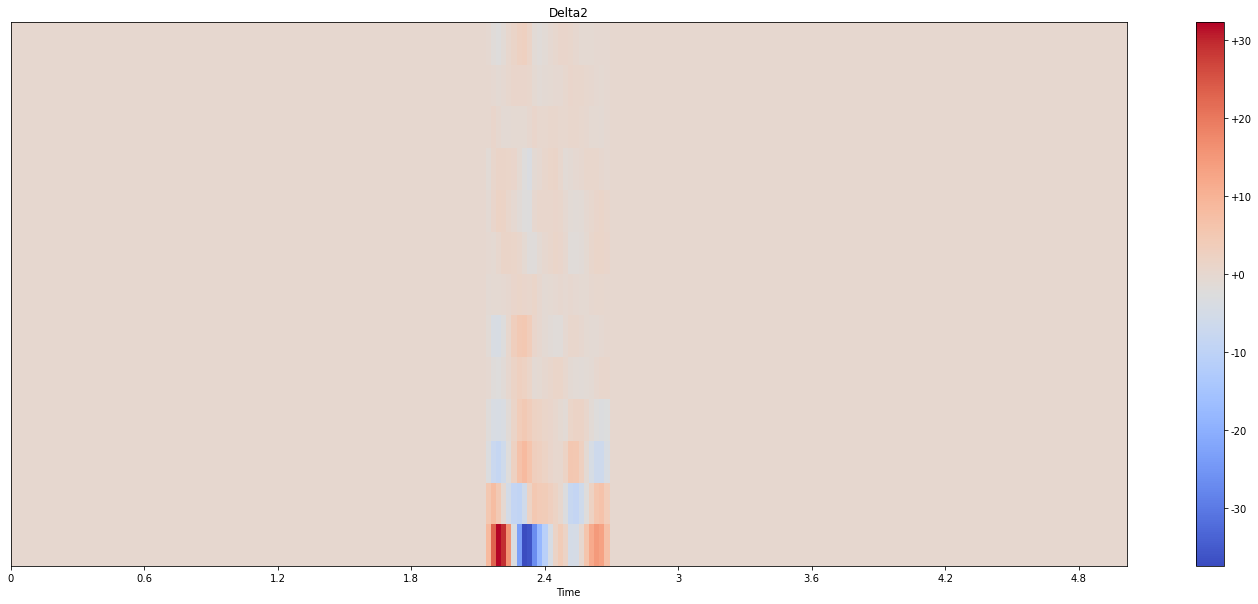

In [87]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(delta2, 
                         x_axis="time", 
                         sr=SAMPLE_RATE)
plt.title('Delta2')
plt.colorbar(format="%+2.f")

# Model Building

In [30]:
mfcc_mean_df = pd.DataFrame(mfcc_mean,columns=['mfcc','class'])
mfcc_mean_df.head()

,mfcc,class
0,"[-600.9692, 4.7353296, -8.546893, -4.235802, -...",dog
1,"[-119.30891, 89.4611, 4.3754106, 20.037407, 8....",crow
2,"[-586.11566, 10.2967415, -3.0421555, -2.837547...",dog
3,"[-499.56836, 123.87773, -17.974522, 29.08289, ...",sheep
4,"[-391.07605, 26.628662, -34.295395, 10.245545,...",frog


In [31]:
X=np.array(mfcc_mean_df['mfcc'].tolist())
y=np.array(mfcc_mean_df['class'].tolist())

In [32]:
X.shape

(400, 13)

In [33]:
y

array(['dog', 'crow', 'dog', 'sheep', 'frog', 'frog', 'cow', 'insects',
       'frog', 'hen', 'hen', 'frog', 'frog', 'frog', 'insects', 'sheep',
       'sheep', 'cow', 'pig', 'pig', 'pig', 'pig', 'pig', 'pig', 'pig',
       'pig', 'rooster', 'rooster', 'dog', 'dog', 'hen', 'hen', 'frog',
       'frog', 'dog', 'cat', 'cat', 'rooster', 'rooster', 'crow', 'crow',
       'rooster', 'rooster', 'rooster', 'rooster', 'insects', 'insects',
       'cat', 'cat', 'cat', 'sheep', 'sheep', 'crow', 'crow', 'cat',
       'cat', 'sheep', 'cow', 'dog', 'hen', 'cow', 'cow', 'hen', 'hen',
       'hen', 'insects', 'crow', 'insects', 'sheep', 'cow', 'cow', 'cat',
       'insects', 'insects', 'cow', 'dog', 'sheep', 'crow', 'crow', 'dog',
       'rooster', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'crow',
       'crow', 'crow', 'crow', 'crow', 'crow', 'crow', 'crow', 'cat',
       'cat', 'sheep', 'sheep', 'dog', 'dog', 'dog', 'dog', 'cow', 'cow',
       'dog', 'dog', 'sheep', 'sheep', 'sheep', 'hen', 'hen', 

In [34]:
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [35]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [36]:
len(y)

400

In [37]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [38]:
X_train

array([[-2.7830710e+02,  7.5848526e+01, -5.0004070e+01, ...,
         4.0881493e+01,  2.1303196e+01, -1.3483344e+01],
       [-1.8381609e+02,  8.5316620e+01, -7.0251762e+01, ...,
        -9.8572445e+00,  1.1738172e+00, -2.4220231e+00],
       [-5.1456226e+02,  1.4515237e+01, -2.9495335e+01, ...,
        -4.2383699e+00, -4.4467707e+00,  9.1441231e+00],
       ...,
       [-9.2712006e+01,  1.6772682e+02, -8.3428411e+00, ...,
         4.6265445e+00,  4.6071887e+00, -4.9508843e-01],
       [-4.3383417e+02,  7.3650238e+01, -1.8852133e+00, ...,
        -2.6578095e+00,  7.6438203e+00, -1.7218331e+00],
       [-3.0167468e+02,  8.2374130e+01, -8.1985464e+00, ...,
         6.9380684e+00, -2.4052999e+00, -2.9396315e+00]], dtype=float32)

In [39]:
X_train.shape

(320, 13)

In [40]:
y_train.shape

(320, 10)

In [41]:
num_labels=y.shape[1]
num_labels

10

    1. ANN

In [61]:
model = Sequential()

model.add(Dense(200,input_dim=13))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [62]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 200)               2800      
_________________________________________________________________
activation_12 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 200)               40200     
_________________________________________________________________
activation_13 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 200)              

In [63]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [64]:
num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='ann_10animal_sound_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 320 samples, validate on 80 samples
Epoch 1/100
224/320 [====================>.........] - ETA: 0s - loss: 22.7641 - accuracy: 0.1116    
Epoch 00001: val_loss improved from inf to 7.26578, saving model to ann_10animal_sound_classification.hdf5
320/320 [==============================] - 2s 7ms/sample - loss: 20.9749 - accuracy: 0.1250 - val_loss: 7.2658 - val_accuracy: 0.1500
Epoch 2/100
256/320 [=======================>......] - ETA: 0s - loss: 11.6449 - accuracy: 0.1328
Epoch 00002: val_loss improved from 7.26578 to 3.84483, saving model to ann_10animal_sound_classification.hdf5
320/320 [==============================] - 1s 2ms/sample - loss: 10.9708 - accuracy: 0.1375 - val_loss: 3.8448 - val_accuracy: 0.1875
Epoch 3/100
288/320 [==========================>...] - ETA: 0s - loss: 7.0563 - accuracy: 0.1771
Epoch 00003: val_loss improved from 3.84483 to 2.77415, saving model to ann_10animal_sound_classification.hdf5
320/320 [==============================] - 1s 2ms/sample - lo

320/320 [==============================] - 0s 1ms/sample - loss: 1.7405 - accuracy: 0.3938 - val_loss: 1.7422 - val_accuracy: 0.4250
Epoch 27/100
256/320 [=======================>......] - ETA: 0s - loss: 1.9163 - accuracy: 0.3438
Epoch 00027: val_loss improved from 1.74218 to 1.73888, saving model to ann_10animal_sound_classification.hdf5
320/320 [==============================] - 1s 2ms/sample - loss: 1.9417 - accuracy: 0.3406 - val_loss: 1.7389 - val_accuracy: 0.4125
Epoch 28/100
256/320 [=======================>......] - ETA: 0s - loss: 1.7352 - accuracy: 0.3594
Epoch 00028: val_loss improved from 1.73888 to 1.69556, saving model to ann_10animal_sound_classification.hdf5
320/320 [==============================] - 1s 2ms/sample - loss: 1.7384 - accuracy: 0.3594 - val_loss: 1.6956 - val_accuracy: 0.4375
Epoch 29/100
288/320 [==========================>...] - ETA: 0s - loss: 1.6954 - accuracy: 0.4167
Epoch 00029: val_loss did not improve from 1.69556
320/320 [=========================

Epoch 54/100
224/320 [====================>.........] - ETA: 0s - loss: 1.4446 - accuracy: 0.4554
Epoch 00054: val_loss did not improve from 1.44781
320/320 [==============================] - 0s 672us/sample - loss: 1.3828 - accuracy: 0.4812 - val_loss: 1.5101 - val_accuracy: 0.5125
Epoch 55/100
224/320 [====================>.........] - ETA: 0s - loss: 1.4975 - accuracy: 0.5045
Epoch 00055: val_loss did not improve from 1.44781
320/320 [==============================] - 0s 737us/sample - loss: 1.4291 - accuracy: 0.5125 - val_loss: 1.4976 - val_accuracy: 0.5375
Epoch 56/100
256/320 [=======================>......] - ETA: 0s - loss: 1.4202 - accuracy: 0.5039
Epoch 00056: val_loss did not improve from 1.44781
320/320 [==============================] - 0s 656us/sample - loss: 1.3910 - accuracy: 0.5250 - val_loss: 1.4785 - val_accuracy: 0.5500
Epoch 57/100
224/320 [====================>.........] - ETA: 0s - loss: 1.1498 - accuracy: 0.5714
Epoch 00057: val_loss did not improve from 1.44781

224/320 [====================>.........] - ETA: 0s - loss: 0.9246 - accuracy: 0.6696
Epoch 00081: val_loss did not improve from 1.28506
320/320 [==============================] - 0s 731us/sample - loss: 1.0035 - accuracy: 0.6531 - val_loss: 1.3427 - val_accuracy: 0.5625
Epoch 82/100
256/320 [=======================>......] - ETA: 0s - loss: 0.9549 - accuracy: 0.6680
Epoch 00082: val_loss did not improve from 1.28506
320/320 [==============================] - 0s 725us/sample - loss: 1.0041 - accuracy: 0.6438 - val_loss: 1.3842 - val_accuracy: 0.5500
Epoch 83/100
256/320 [=======================>......] - ETA: 0s - loss: 0.9863 - accuracy: 0.6562
Epoch 00083: val_loss did not improve from 1.28506
320/320 [==============================] - 0s 728us/sample - loss: 0.9959 - accuracy: 0.6594 - val_loss: 1.4083 - val_accuracy: 0.5750
Epoch 84/100
224/320 [====================>.........] - ETA: 0s - loss: 1.0450 - accuracy: 0.6250
Epoch 00084: val_loss did not improve from 1.28506
320/320 [===

In [65]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.625


In [66]:
model.predict_classes(X_test)

array([4, 0, 6, 1, 4, 3, 0, 0, 5, 5, 3, 4, 3, 6, 9, 5, 9, 8, 5, 3, 3, 8,
       7, 8, 1, 3, 2, 9, 9, 1, 2, 1, 0, 7, 7, 4, 2, 0, 2, 0, 5, 0, 0, 2,
       5, 0, 2, 7, 6, 4, 4, 3, 6, 8, 6, 4, 2, 3, 8, 6, 1, 6, 0, 9, 8, 5,
       6, 0, 0, 7, 6, 0, 9, 7, 8, 7, 3, 1, 8, 4], dtype=int64)

In [67]:
filename = 'C:\\Users\\Kaviarasan\\Data Science\\Data Sets\\esc_50\\audio\\1-100032-A-0.wav'
ipd.Audio(filename)

In [68]:
signal,sr = librosa.load(filename, res_type='kaiser_fast') 
mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
mfccs_scaled_features = np.mean(mfcc.T,axis=0)
mfccs = mfccs_scaled_features.reshape(1,-1)
predicted_label=model.predict_classes(mfccs)
print('Predicted label :',predicted_label)

prediction_class = labelencoder.inverse_transform(predicted_label) 
print('Predicted animal :',prediction_class)

Predicted label : [3]
Predicted animal : ['dog']


    2. CNN

In [95]:
X = np.array(mfcc)
y = np.array(labels)

In [96]:
y

array(['dog', 'crow', 'dog', 'sheep', 'frog', 'frog', 'cow', 'insects',
       'frog', 'hen', 'hen', 'frog', 'frog', 'frog', 'insects', 'sheep',
       'sheep', 'cow', 'pig', 'pig', 'pig', 'pig', 'pig', 'pig', 'pig',
       'pig', 'rooster', 'rooster', 'dog', 'dog', 'hen', 'hen', 'frog',
       'frog', 'dog', 'cat', 'cat', 'rooster', 'rooster', 'crow', 'crow',
       'rooster', 'rooster', 'rooster', 'rooster', 'insects', 'insects',
       'cat', 'cat', 'cat', 'sheep', 'sheep', 'crow', 'crow', 'cat',
       'cat', 'sheep', 'cow', 'dog', 'hen', 'cow', 'cow', 'hen', 'hen',
       'hen', 'insects', 'crow', 'insects', 'sheep', 'cow', 'cow', 'cat',
       'insects', 'insects', 'cow', 'dog', 'sheep', 'crow', 'crow', 'dog',
       'rooster', 'cow', 'cow', 'cow', 'cow', 'cow', 'cow', 'crow',
       'crow', 'crow', 'crow', 'crow', 'crow', 'crow', 'crow', 'cat',
       'cat', 'sheep', 'sheep', 'dog', 'dog', 'dog', 'dog', 'cow', 'cow',
       'dog', 'dog', 'sheep', 'sheep', 'sheep', 'hen', 'hen', 

In [97]:
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [98]:
X.shape

(400, 13, 216)

In [99]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [101]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=0)

In [102]:
X_train = X_train[...,np.newaxis]
X_test = X_test[...,np.newaxis]

In [103]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((360, 13, 216, 1), (360, 10), (40, 13, 216, 1), (40, 10))

In [110]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1],X_train.shape[2],1),
                 kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))

model.add(Conv2D(32, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3), strides=(2,2), padding='same'))

model.add(Conv2D(32, (2, 2), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2,2), padding='same'))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(10, activation='softmax'))

optimiser =Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser,
              loss='categorical_crossentropy',
              metrics=["accuracy"])

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 11, 214, 64)       640       
_________________________________________________________________
batch_normalization_7 (Batch (None, 11, 214, 64)       256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 107, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 105, 32)        18464     
_________________________________________________________________
batch_normalization_8 (Batch (None, 4, 105, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 2, 53, 32)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 52, 32)        

In [111]:
num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='cnn_10animal_sound_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 360 samples, validate on 40 samples
Epoch 1/100
352/360 [============================>.] - ETA: 0s - loss: 2.8144 - accuracy: 0.3097
Epoch 00001: val_loss improved from inf to 240.51378, saving model to cnn_10animal_sound_classification.hdf5
360/360 [==============================] - 25s 70ms/sample - loss: 2.8871 - accuracy: 0.3111 - val_loss: 240.5138 - val_accuracy: 0.0750
Epoch 2/100
352/360 [============================>.] - ETA: 0s - loss: 1.9954 - accuracy: 0.4858
Epoch 00002: val_loss improved from 240.51378 to 105.35899, saving model to cnn_10animal_sound_classification.hdf5
360/360 [==============================] - 22s 60ms/sample - loss: 1.9816 - accuracy: 0.4889 - val_loss: 105.3590 - val_accuracy: 0.1250
Epoch 3/100
352/360 [============================>.] - ETA: 0s - loss: 1.4636 - accuracy: 0.6136
Epoch 00003: val_loss improved from 105.35899 to 62.20545, saving model to cnn_10animal_sound_classification.hdf5
360/360 [==============================] - 18s 50ms/

Epoch 27/100
352/360 [============================>.] - ETA: 0s - loss: 0.6076 - accuracy: 0.8750
Epoch 00027: val_loss did not improve from 2.61807
360/360 [==============================] - 18s 50ms/sample - loss: 0.6089 - accuracy: 0.8722 - val_loss: 2.6844 - val_accuracy: 0.5000
Epoch 28/100
352/360 [============================>.] - ETA: 0s - loss: 0.4860 - accuracy: 0.8835
Epoch 00028: val_loss improved from 2.61807 to 1.98956, saving model to cnn_10animal_sound_classification.hdf5
360/360 [==============================] - 18s 51ms/sample - loss: 0.4940 - accuracy: 0.8833 - val_loss: 1.9896 - val_accuracy: 0.5750
Epoch 29/100
352/360 [============================>.] - ETA: 0s - loss: 0.4697 - accuracy: 0.8920
Epoch 00029: val_loss did not improve from 1.98956
360/360 [==============================] - 19s 52ms/sample - loss: 0.4667 - accuracy: 0.8944 - val_loss: 3.1627 - val_accuracy: 0.5250
Epoch 30/100
352/360 [============================>.] - ETA: 0s - loss: 0.4425 - accurac

Epoch 56/100
352/360 [============================>.] - ETA: 0s - loss: 0.5805 - accuracy: 0.9006
Epoch 00056: val_loss did not improve from 1.93350
360/360 [==============================] - 19s 52ms/sample - loss: 0.5977 - accuracy: 0.8972 - val_loss: 3.1100 - val_accuracy: 0.5750
Epoch 57/100
352/360 [============================>.] - ETA: 0s - loss: 0.5991 - accuracy: 0.8636
Epoch 00057: val_loss did not improve from 1.93350
360/360 [==============================] - 19s 53ms/sample - loss: 0.5990 - accuracy: 0.8639 - val_loss: 2.5818 - val_accuracy: 0.6000
Epoch 58/100
352/360 [============================>.] - ETA: 0s - loss: 0.4571 - accuracy: 0.9261
Epoch 00058: val_loss did not improve from 1.93350
360/360 [==============================] - 19s 53ms/sample - loss: 0.4524 - accuracy: 0.9278 - val_loss: 2.6621 - val_accuracy: 0.6000
Epoch 59/100
352/360 [============================>.] - ETA: 0s - loss: 0.5052 - accuracy: 0.9176
Epoch 00059: val_loss did not improve from 1.93350

Epoch 85/100
352/360 [============================>.] - ETA: 0s - loss: 0.4873 - accuracy: 0.9318
Epoch 00085: val_loss did not improve from 1.93350
360/360 [==============================] - 20s 55ms/sample - loss: 0.4828 - accuracy: 0.9333 - val_loss: 1.9587 - val_accuracy: 0.6250
Epoch 86/100
352/360 [============================>.] - ETA: 0s - loss: 0.4040 - accuracy: 0.9545
Epoch 00086: val_loss improved from 1.93350 to 1.53534, saving model to cnn_10animal_sound_classification.hdf5
360/360 [==============================] - 20s 55ms/sample - loss: 0.4123 - accuracy: 0.9528 - val_loss: 1.5353 - val_accuracy: 0.6750
Epoch 87/100
352/360 [============================>.] - ETA: 0s - loss: 0.3904 - accuracy: 0.9574
Epoch 00087: val_loss improved from 1.53534 to 1.47464, saving model to cnn_10animal_sound_classification.hdf5
360/360 [==============================] - 20s 54ms/sample - loss: 0.3895 - accuracy: 0.9583 - val_loss: 1.4746 - val_accuracy: 0.6750
Epoch 88/100
352/360 [======

In [112]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.6


In [113]:
model.predict_classes(X_test)

array([4, 0, 1, 1, 6, 6, 8, 0, 2, 0, 8, 4, 3, 6, 5, 5, 4, 2, 5, 3, 0, 3,
       1, 8, 1, 3, 2, 9, 1, 6, 2, 1, 0, 0, 6, 9, 2, 2, 2, 2], dtype=int64)

In [114]:
filename = 'C:\\Users\\Kaviarasan\\Data Science\\Data Sets\\esc_50\\audio\\1-100032-A-0.wav'
ipd.Audio(filename)

In [118]:
signal,sr = librosa.load(filename, res_type='kaiser_fast') 
mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
mfcc.shape

(13, 216)

In [122]:
x = mfcc[np.newaxis,...,np.newaxis]
x.shape

(1, 13, 216, 1)

In [123]:
predicted_label=model.predict_classes(x)
print('Predicted label :',predicted_label)

prediction_class = labelencoder.inverse_transform(predicted_label) 
print('Predicted animal :',prediction_class)

Predicted label : [3]
Predicted animal : ['dog']
